# Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras_cv

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.16.1
TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 0


## ⏳ Load the Data

In [2]:
data = np.load('/kaggle/input/dataset/mars_for_students.npz')

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


### Data exploration

In [3]:
def display_color_mapped_image_continuous(image, n_colors=5):
    '''
    associates at every different class a different color
    Inputs:
        -image: contains the image to be processed
        -n_colors: contains the number of color with color the image
    Output:
        -colored_image: contains the image processed
    '''
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_colors))
    #print(colors)

    # Map the colors
    colored_image = colors[image.astype(int)]

    return colored_image

def plot_sample_images(X, mask, num_row):
    '''
    Plot 2*num_row images from X with their masks organizing them in subplots in the form num_row * 4
    Inputs:
        -X: vector that contains the images to be shown
        -mask: vecctor that contains the masks of the realtive images
        -num_row: number of rows that will be shown
    Outputs:
        None
    '''
    
    fig, axes = plt.subplots(num_row, 4,figsize=(30,3*num_row+10))
    iter=1
    for i in range(2*num_row):
        #plot the image
        index = np.random.randint(0,len(X))
        ax=plt.subplot(num_row,4,iter)
        ax.set_title(f"Image {index}")
        ax.imshow(X[index],cmap='gray')
        ax.axis('off')

        iter=iter+1

        #plot the relative mask
        ax=plt.subplot(num_row,4,iter)
        ax.set_title(f"Mask {index}")
        colored_image = display_color_mapped_image_continuous(mask[index])
        ax.imshow(np.squeeze(colored_image))
        ax.axis('off')
        iter=iter+1
    plt.show()

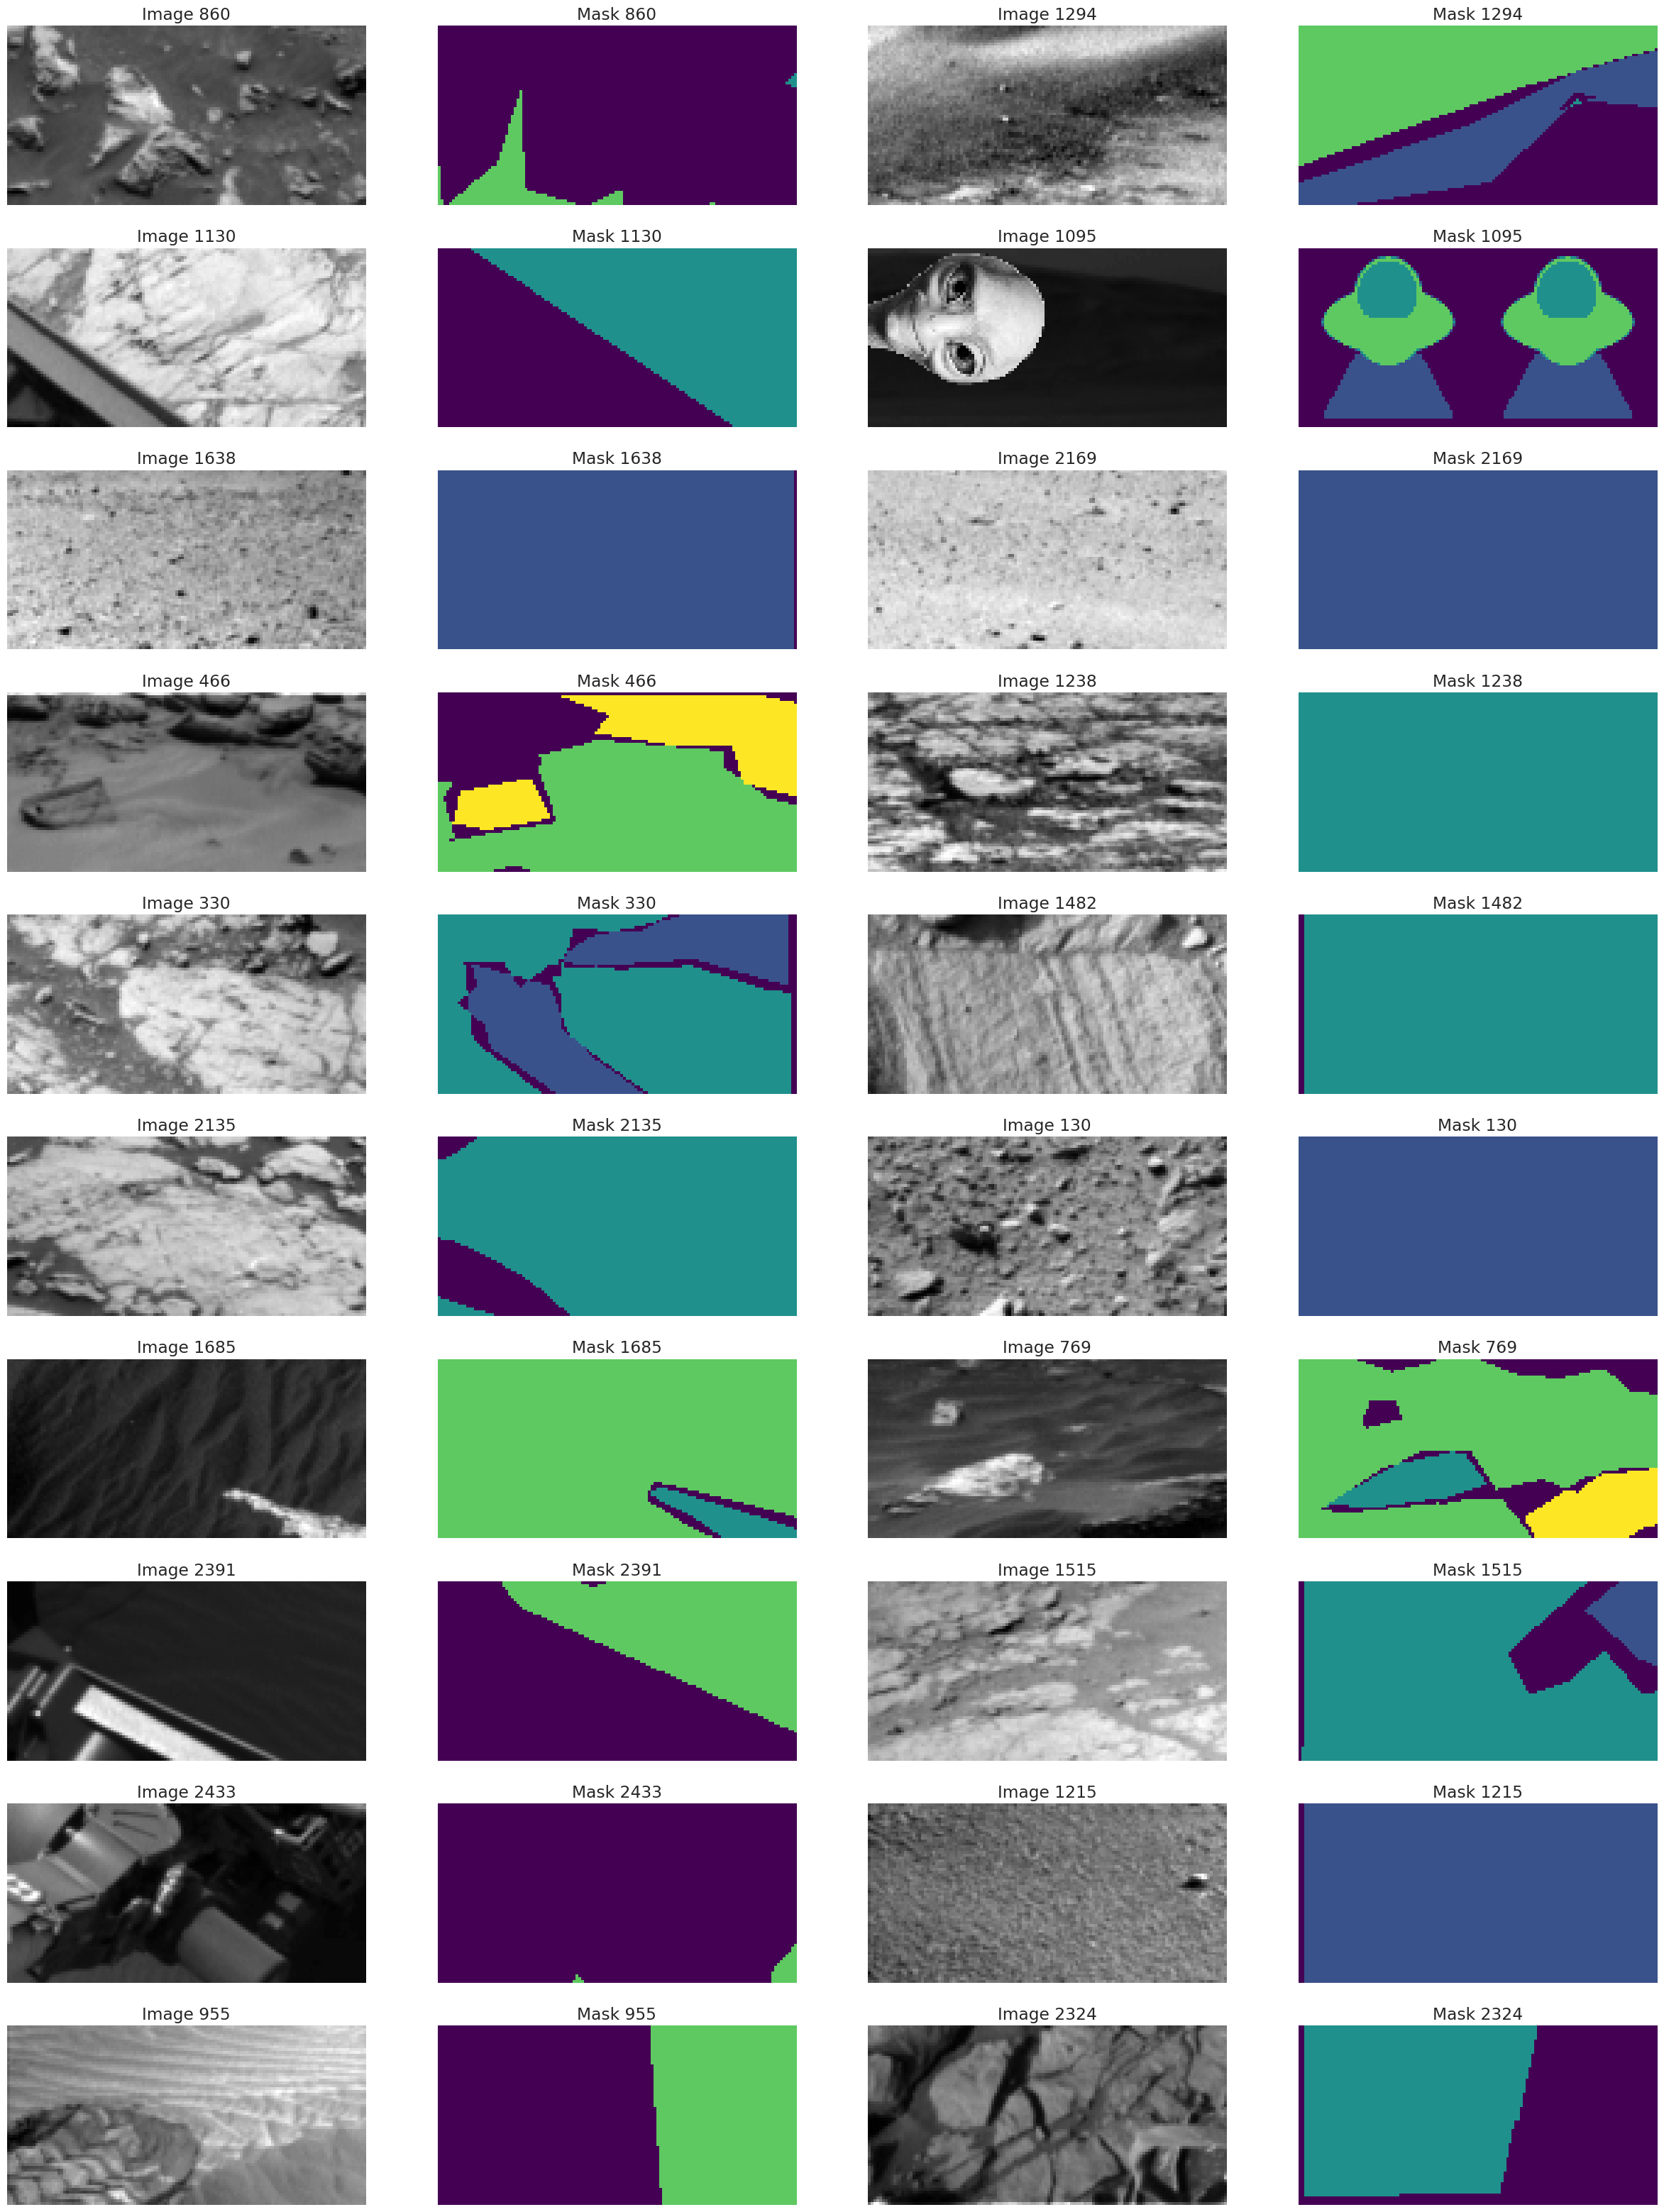

In [4]:
# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

We need to clean the dataset from the outlier like the image at the index 79 that contains an alien

In [5]:
indecesAlien=[]

for i in range(max(y_train.shape)):
    #check if the massk is equal to the number 79 that is taken as reference
    if (y_train[i] == y_train[79]).all(): 
        indecesAlien.append(i)

print(len(indecesAlien))
#delete the alien images
X_train = np.delete(X_train, indecesAlien, axis=0) 
y_train = np.delete(y_train, indecesAlien, axis=0)

110


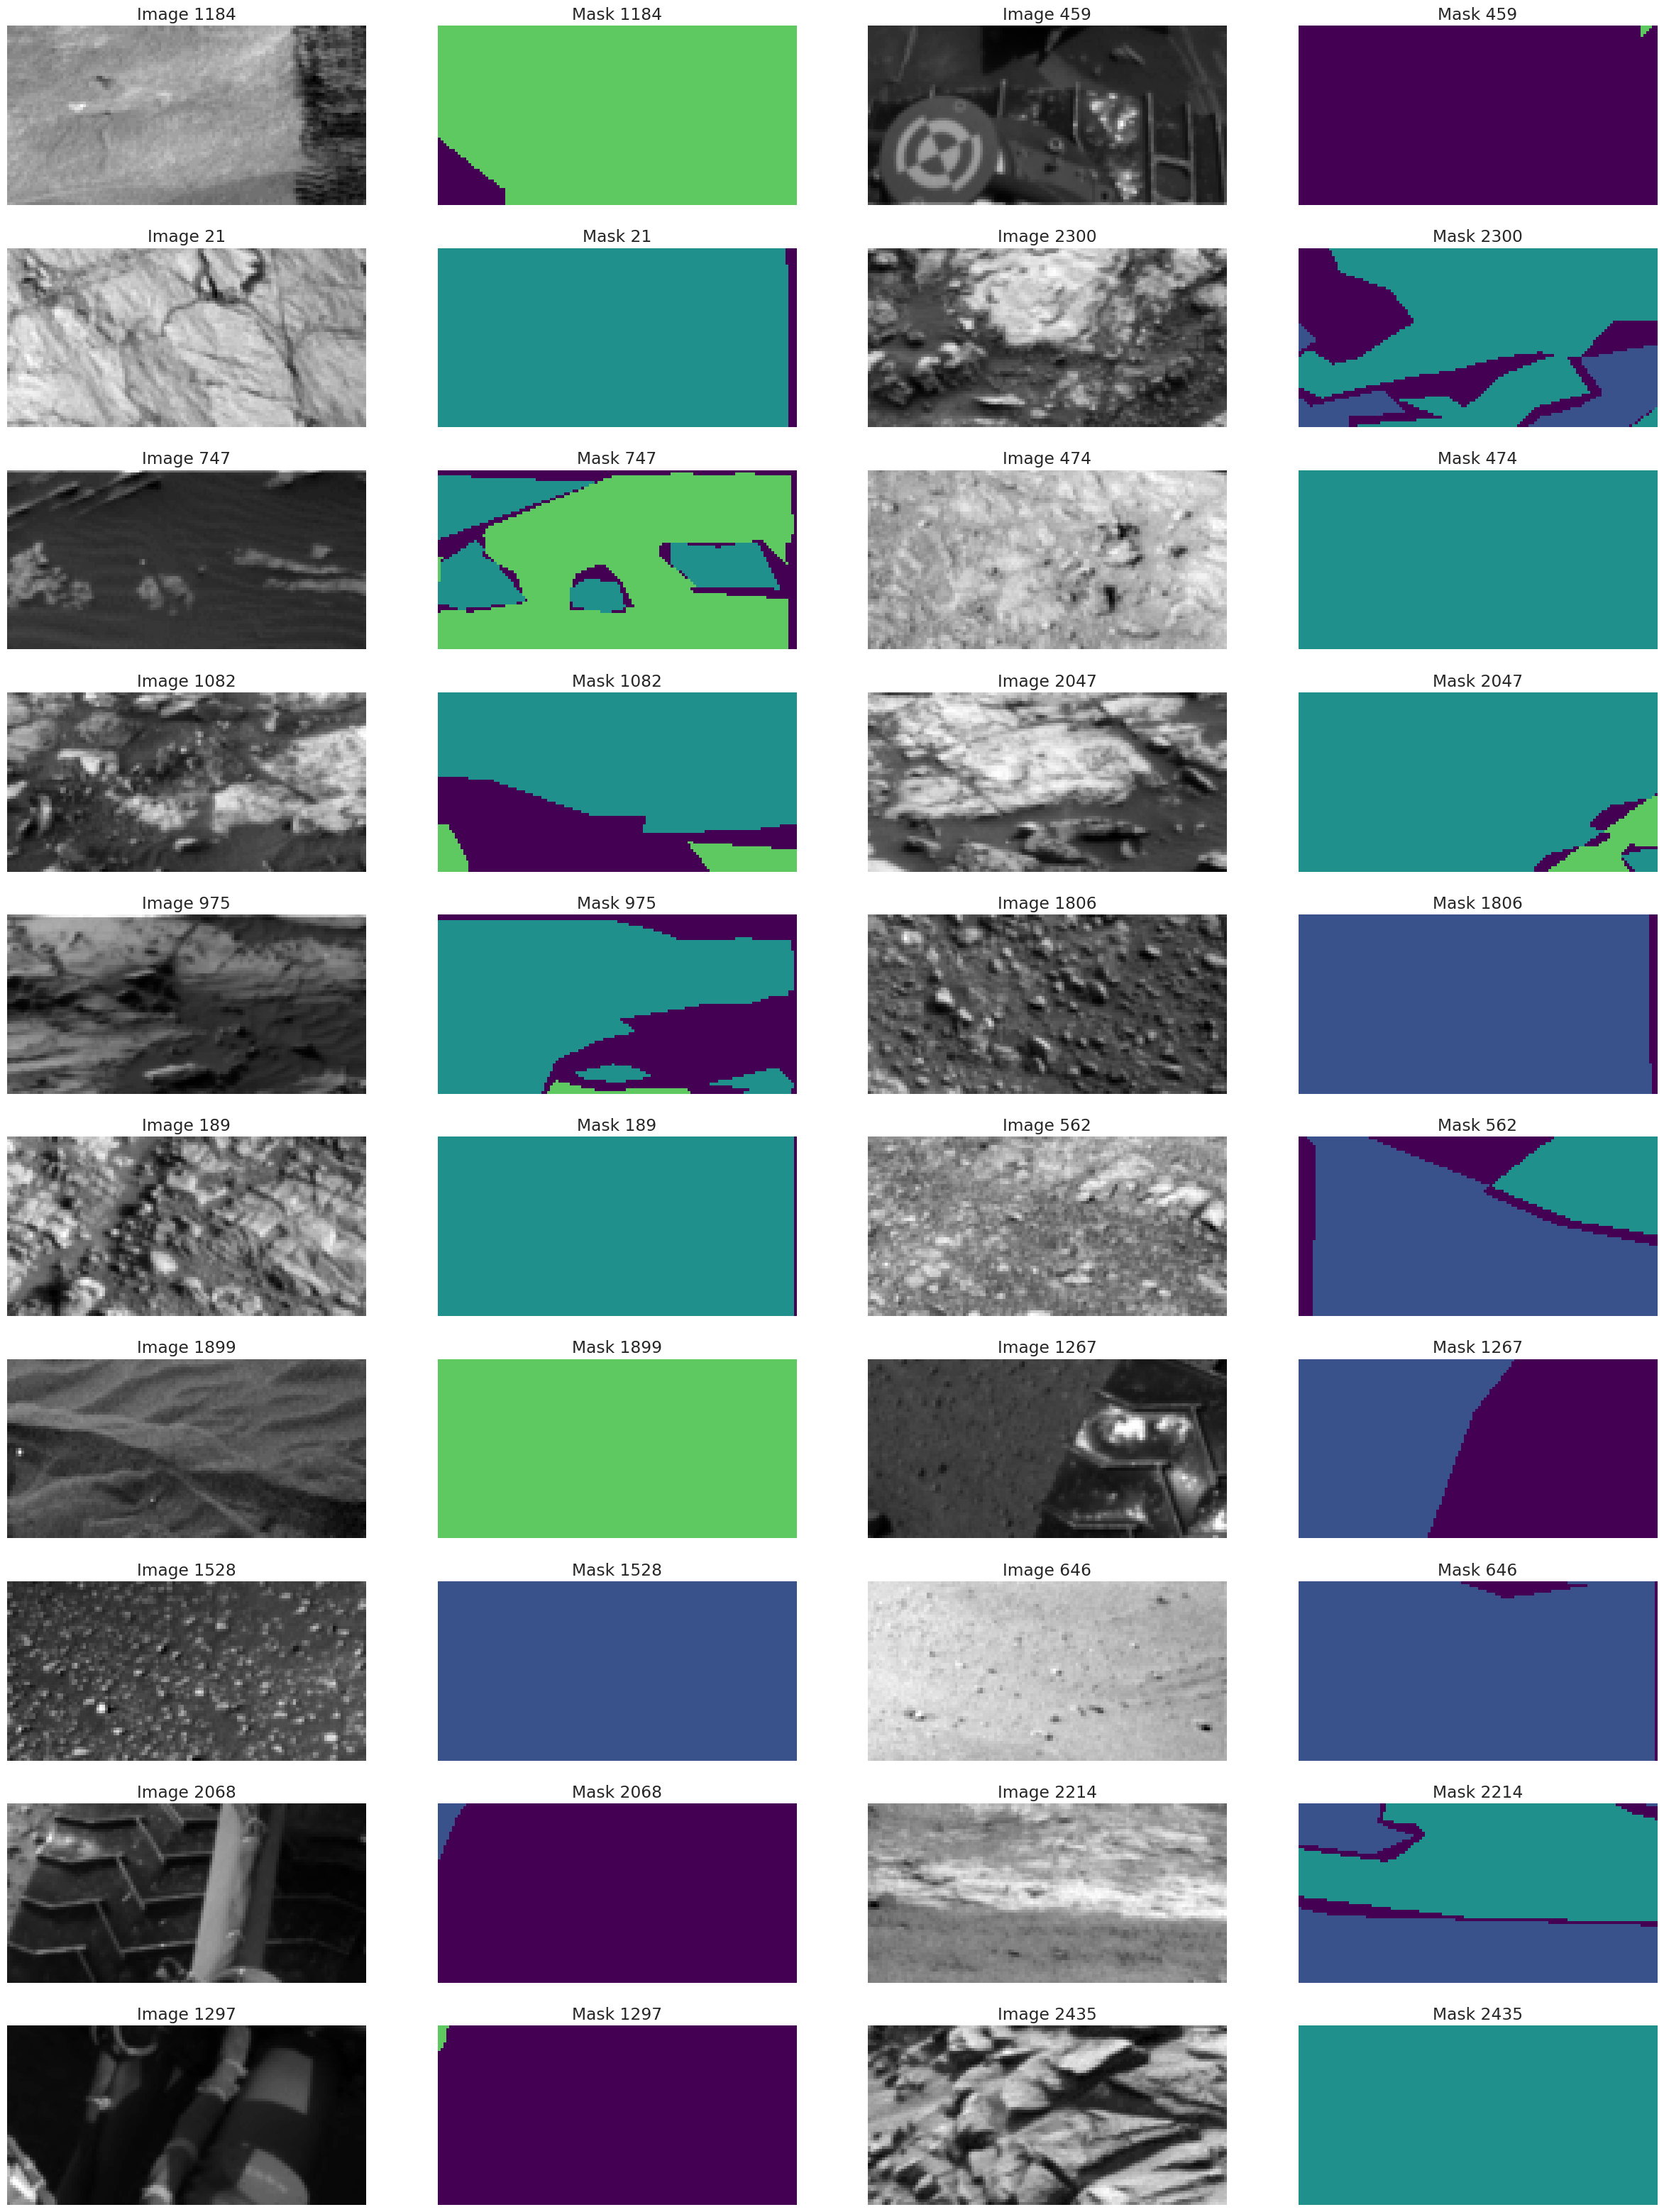

In [6]:
# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

## Preprocessing data

In [7]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=seed)

print(f"Shapes after splitting:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

print(f'\nunique classes: {len(np.unique(y_train))}')

Shapes after splitting:
X_train: (1753, 64, 128)
y_train: (1753, 64, 128)
X_val: (752, 64, 128)
y_val: (752, 64, 128)

unique classes: 5


In [8]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train[..., np.newaxis]

In [9]:
def count_img_per_class(y_train):
    '''
    Divides the images depending on the class that they contain
    Input:
        -y_train: vector of the masks
    Output:
        -index_divided_class: list of 5 (which is the number of classes) vectors. Each vector contains the indexes of the images of the class 
    '''
    index_divided_class=[]
    
    for j in range(len(np.unique(y_train))): #cicle over the classes
        temp=[]
        for i in range(len(y_train)): #cicle over the indexes
            if (y_train[i]==j).any():
                temp.append(i)
        index_divided_class.append(temp)
    
    for i in range(len(index_divided_class)):
        print(f'Class {i} has {len(index_divided_class[i])}')
    return index_divided_class

In [10]:
#check the distribution and the shape of my dataset
print(f'x_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nx_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nunique classes: {len(np.unique(y_train))}')
index_divided_class=count_img_per_class(y_train)

x_train shape: (1753, 64, 128, 1)
y_train shape: (1753, 64, 128, 1)
x_val shape: (752, 64, 128, 1)
y_val shape: (752, 64, 128)
unique classes: 5
Class 0 has 1475
Class 1 has 874
Class 2 has 848
Class 3 has 612
Class 4 has 50


It's clear that class 4 ('big rock') is very rare so we will augment that class

## Cut and Paste

In [11]:
def CutAndPaste(Xa,ya,Xb,yb):
    '''
    Copy and paste the big rocks on a given other image and trsforms the mask accordingly
    Inputs:
        -Xa: image on which the rock will be pasted
        -ya: mask of the image in Xa
        -Xb: image that contains the rock
        -yb: mask of the image in Xb
    Output:
        -Xres: final image 
        -yres: final mask
    '''
    Xtemp=np.zeros(Xa.shape)
    ytemp=np.zeros(ya.shape)
    Xres=np.copy(Xa)
    yres=np.copy(ya)
    
    for i in range(yb.shape[0]):
        for j in range(yb.shape[1]):
            if yb[i][j]==4:
                Xtemp[i][j]=Xb[i][j]
                ytemp[i][j]=yb[i][j]

    Xtemp,ytemp=RandomAugmentationCustom(Xtemp,ytemp,False)

    for i in range(yb.shape[0]):
        for j in range(yb.shape[1]):
            if ytemp[i][j]==4 or ytemp[max(0,i-1)][j]==4 or ytemp[min(yb.shape[0]-1,i+1)][j]==4 or ytemp[i][max(0,j-1)]==4 or ytemp[i][min(yb.shape[1]-1,j+1)]==4:
                Xres[i][j]=Xtemp[i][j]
                yres[i][j]=ytemp[i][j]
            
    return Xres,yres

In [12]:
def RandomAugmentationCustom(X,Y,crop_bool):
    '''
    Makes augmentation on the image given in input
    Inputs:
        -X: contains the image to augment
        -Y: contains the mask of the image
        -crop_bool: variable that check if do or not the crop on the image
    Output:
        -X: contains the image augmented
        -Y: contains the mask of the image augmented accordingly
    '''
    N=np.random.choice([2,3,5,7,11,6,10,17,22,6,15,21,33,30,35,55,14,21,77]) #determines which augmentation do
    
    if N%2==0:
        X=tf.image.flip_left_right(X)
        Y=tf.image.flip_left_right(Y)
    if N%3==0:
        X=tf.image.flip_up_down(X)
        Y=tf.image.flip_up_down(Y)

    if N%5==0:
        angle=(np.random.random()*2-1)*0.3
        
        X=tfkl.RandomRotation(factor=(angle,angle),fill_mode="wrap",interpolation="nearest")(X)
        Y=tfkl.RandomRotation(factor=(angle,angle),fill_mode="wrap",interpolation="nearest")(Y)

    if N%7==0:
        height_factor=(np.random.random()*2-1)*0.3
        width_factor=(np.random.random()*2-1)*0.3
    
        X=tfkl.RandomTranslation(height_factor=(height_factor,height_factor),width_factor=(width_factor,width_factor),fill_mode="wrap",interpolation="nearest")(X)
        Y=tfkl.RandomTranslation(height_factor=(height_factor,height_factor),width_factor=(width_factor,width_factor),fill_mode="wrap",interpolation="nearest")(Y)
        
    if crop_bool and N%11==0:
        
        crop_factor_X=np.random.random()*0.6
        crop_factor_Y=np.random.random()*0.6
        
        X=tf.image.crop_and_resize(X[None, :, :,:],boxes=np.asarray([[crop_factor_X,crop_factor_Y,1,1]]),box_indices=[0],crop_size=(64,128),method='nearest')
        Y=tf.image.crop_and_resize(Y[None, :, :,:],boxes=np.asarray([[crop_factor_X,crop_factor_Y,1,1]]),box_indices=[0],crop_size=(64,128),method='nearest')
        
    return X,Y

(-0.5, 127.5, 63.5, -0.5)

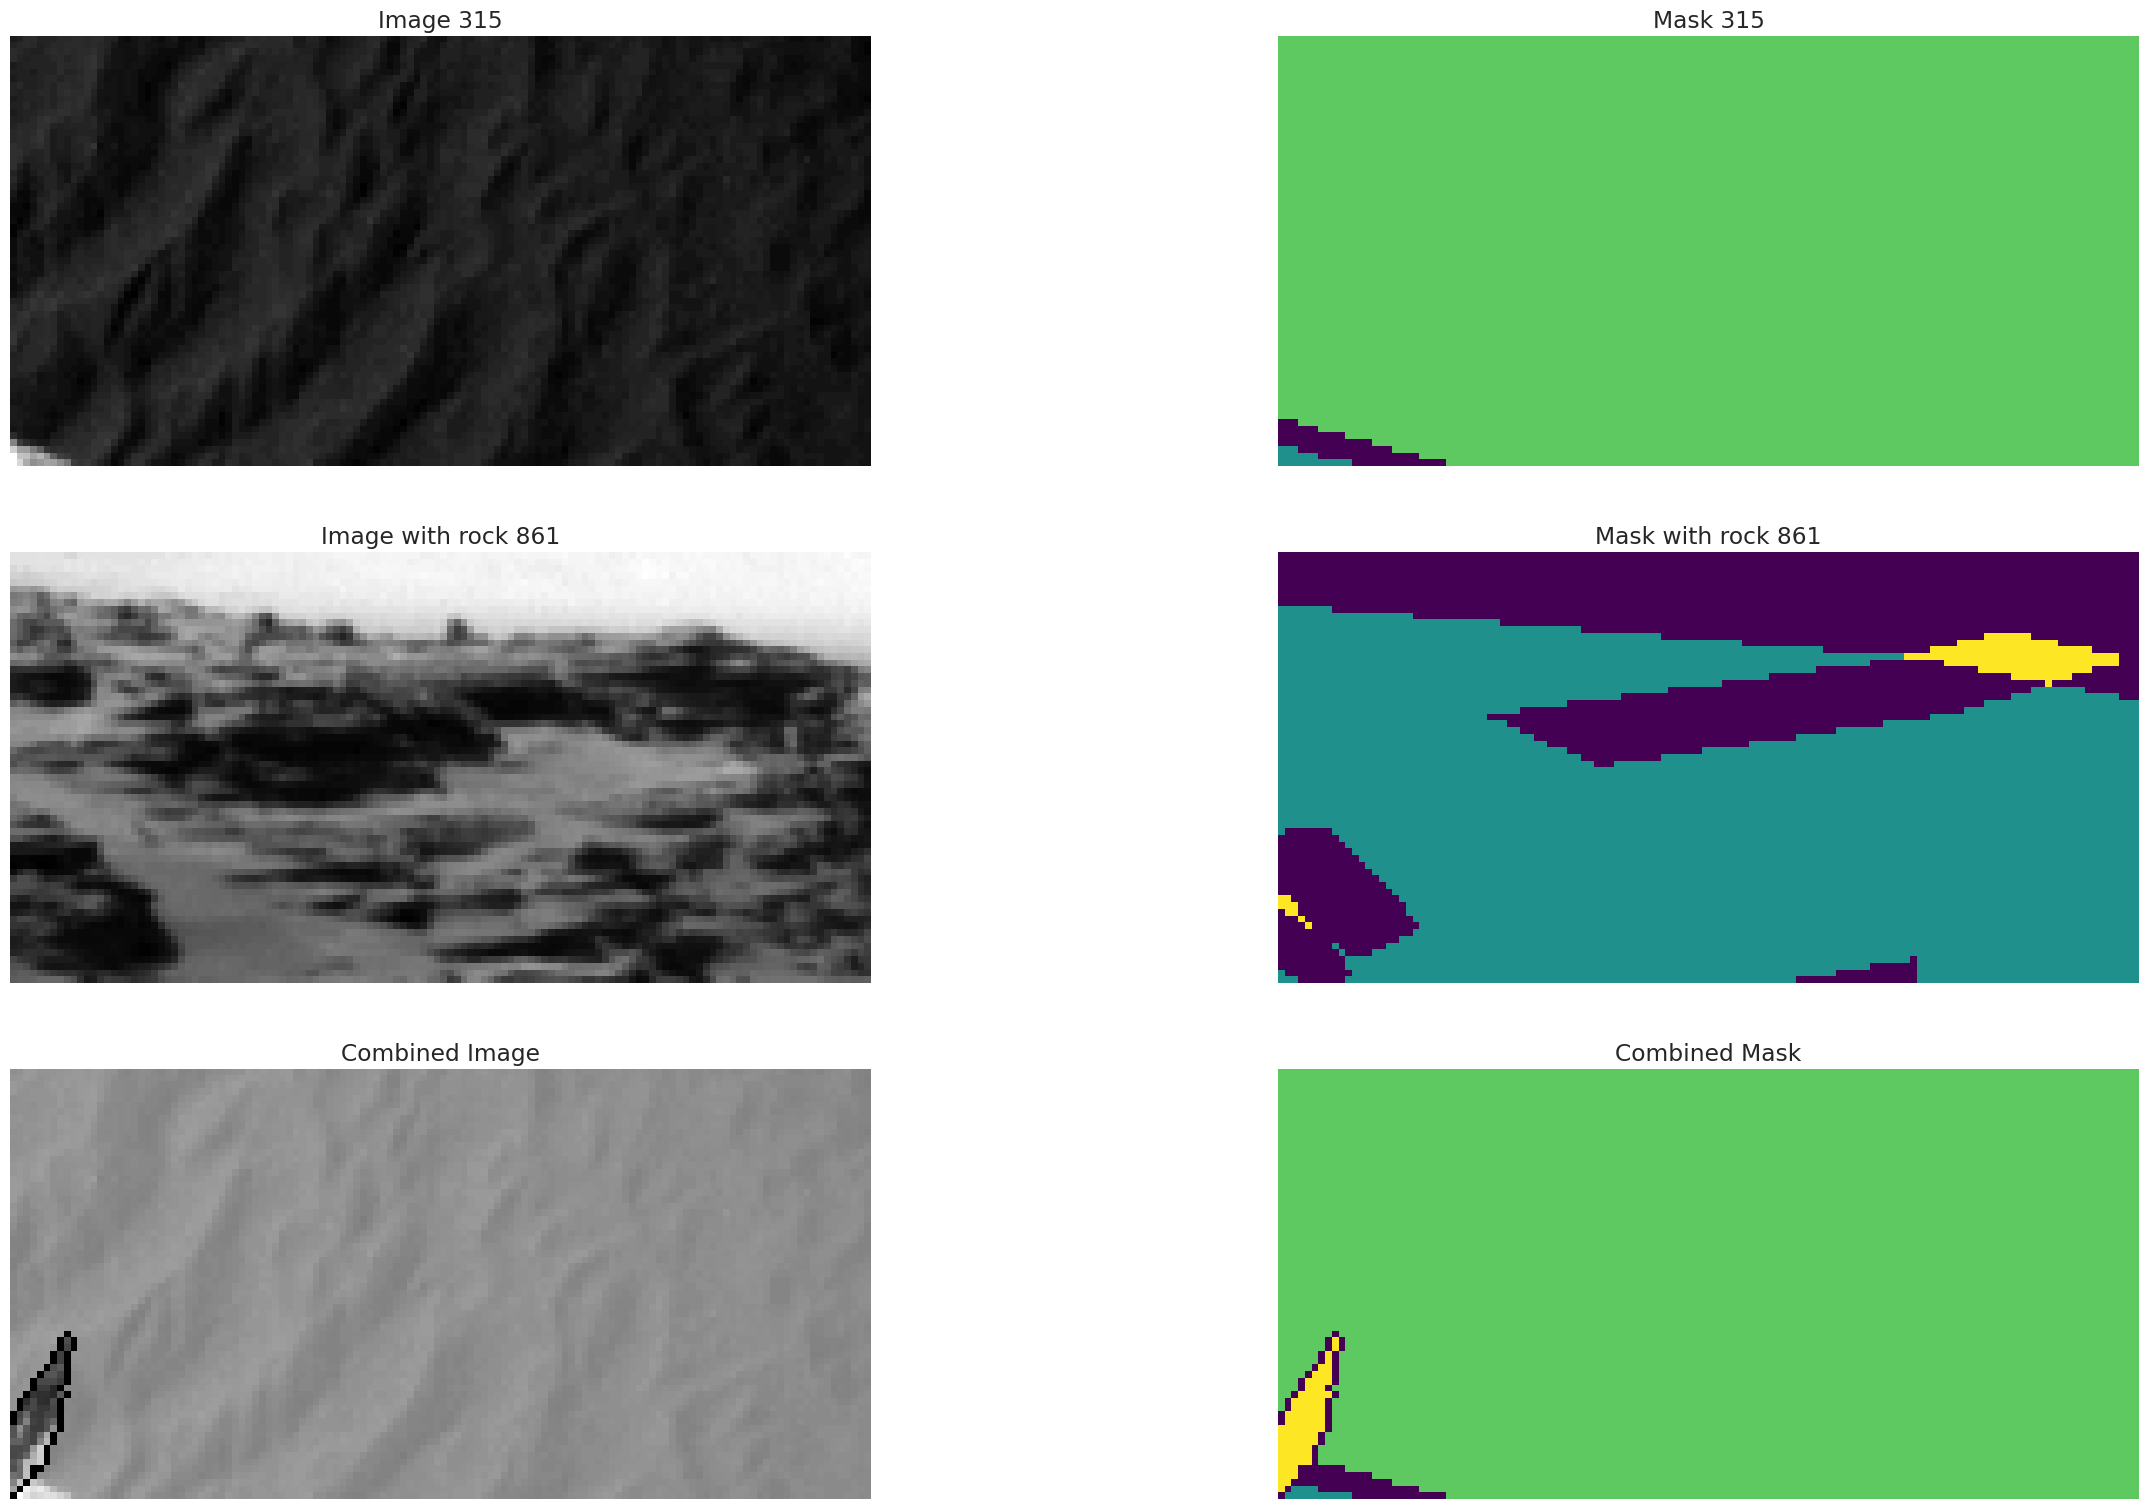

In [13]:
#check that the function CutAndPaste(Xa,ya,Xb,yb) works properly plotting the to images used as base and the augmented one with respective masks

indRock=np.random.choice(index_divided_class[-1])
index=np.random.randint(len(X_train))

Xaug,Yaug= CutAndPaste(X_train[index],y_train[index],X_train[indRock],y_train[indRock])

fig,axis=plt.subplots(3, 2,figsize=(30,19))

ax=plt.subplot(3,2,1)
ax.set_title(f"Image {index}")
ax.imshow(np.squeeze(X_train[index]),cmap='gray')
ax.axis('off')

ax=plt.subplot(3,2,2)
ax.set_title(f"Mask {index}")
colored_image = display_color_mapped_image_continuous(y_train[index])
ax.imshow(np.squeeze(colored_image))
ax.axis('off')

ax=plt.subplot(3,2,3)
ax.set_title(f"Image with rock {indRock}")
ax.imshow(np.squeeze(X_train[indRock]),cmap='gray')
ax.axis('off')

ax=plt.subplot(3,2,4)
ax.set_title(f"Mask with rock {indRock}")
colored_image = display_color_mapped_image_continuous(y_train[indRock])
ax.imshow(np.squeeze(colored_image))
ax.axis('off')

ax=plt.subplot(3,2,5)
ax.set_title(f"Combined Image")
ax.imshow(np.squeeze(Xaug),cmap='gray')
ax.axis('off')

ax=plt.subplot(3,2,6)
ax.set_title(f"Combined Mask")
colored_image = display_color_mapped_image_continuous(np.array(Yaug))
ax.imshow(np.squeeze(colored_image))
ax.axis('off')

In [14]:
def augmentWithCutPaste(X,Y,num,indexes=index_divided_class[-1]):
    '''
    Apply the cut and paste augmentation making also augmentation in order to generate other num images (to speed up don't call the function above but it is integrated here)
    Inputs:
        -X: contains the entire dataset of images
        -Y: contains the masks of the entire dataset
        -num: number of images to generate
        -indexes: indexes of the images that contains the big rock
    Outputs:
        -X: contains the X vector received as input and the generated images
        -Y: contains the Y vector received as input and the masks relative to the generated images
    '''
    
    N=len(X_train)
    #allocate the space in memory
    X=np.resize(X,(num+N,64,128,1))
    Y=np.resize(Y,(num+N,64,128,1))

    Xtemp=np.zeros((len(indexes),64,128,1))
    Ytemp=np.zeros((len(indexes),64,128,1))

    Xtemp1=np.zeros((64,128,1))
    Ytemp1=np.zeros((64,128,1))

    #Make an intermediate output in order to flip,rotate,... only the rock using only the image that has at least 15 pixel of class 4
    l=0
    for k in indexes:
        if np.sum(Y[k]==4)>15:
            for i in range(64):
                for j in range(128):
                    if Y[k][i][j]==4 or Y[k][max(0,i-1)][j]==4 or Y[k][min(63,i+1)][j]==4 or Y[k][i][max(0,j-1)]==4 or Y[k][i][min(127,j+1)]==4:
                        Xtemp[l][i][j]=X[k][i][j]
                        Ytemp[l][i][j]=Y[k][i][j]
            l=l+1

    #Populate the vector
    for l in range(N,num+N):
        index=np.random.randint(N) #index of the image used as base

        indRock=np.random.randint(len(Xtemp))
        
        Xtemp1,ytemp1=RandomAugmentationCustom(Xtemp[indRock],Ytemp[indRock],False) #augment the intermediate output
        
        X[l]=np.copy(X[index])
        Y[l]=np.copy(Y[index])

        #paste the rock
        for i in range(64):
            for j in range(128):
                if ytemp1[i][j]==4:
                    X[l][i][j]=Xtemp1[i][j]
                    Y[l][i][j]=ytemp1[i][j]

    return X,Y

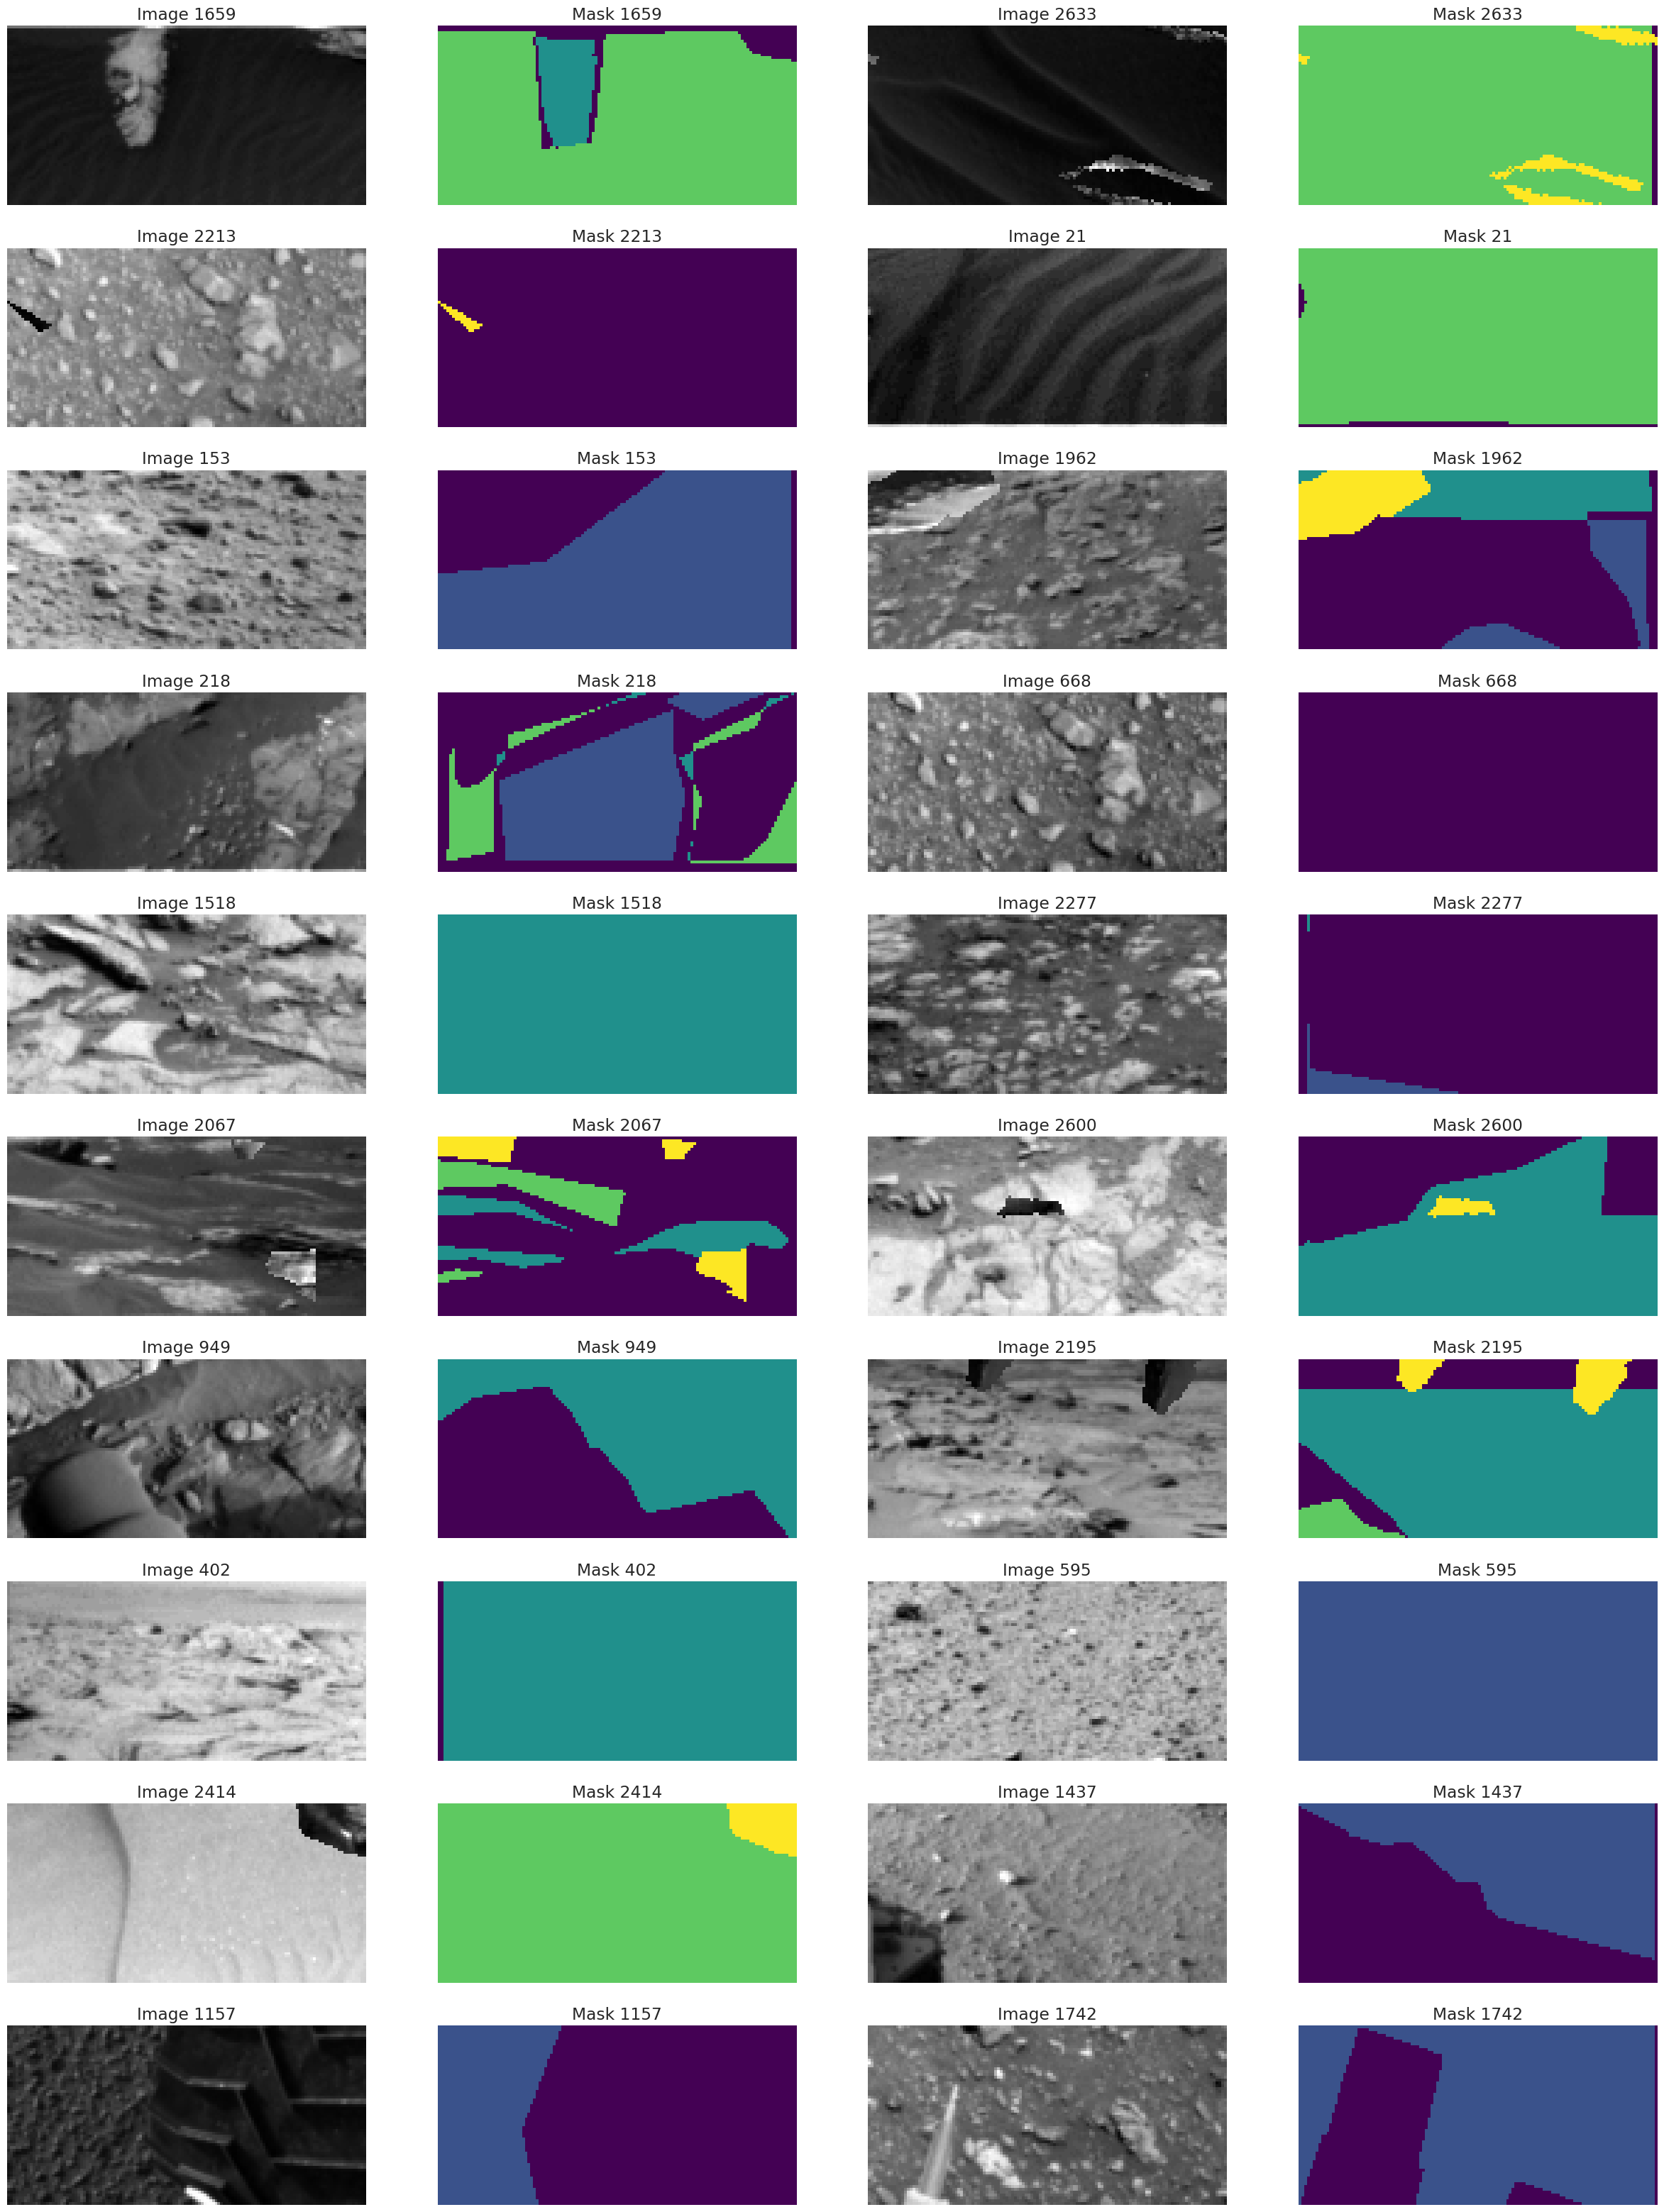

In [15]:
#apply the augmentation described above
X_train,y_train=augmentWithCutPaste(X=X_train,Y=y_train,num=1000,indexes=index_divided_class[-1])

# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

In [16]:
#check over the distribution and shape of the dataset
print(f'x_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nx_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nunique classes: {len(np.unique(y_train))}')
index_divided_class=count_img_per_class(y_train)

x_train shape: (2753, 64, 128, 1)
y_train shape: (2753, 64, 128, 1)
x_val shape: (752, 64, 128, 1)
y_val shape: (752, 64, 128)
unique classes: 5
Class 0 has 2328
Class 1 has 1367
Class 2 has 1343
Class 3 has 964
Class 4 has 872


### Data Augmentation

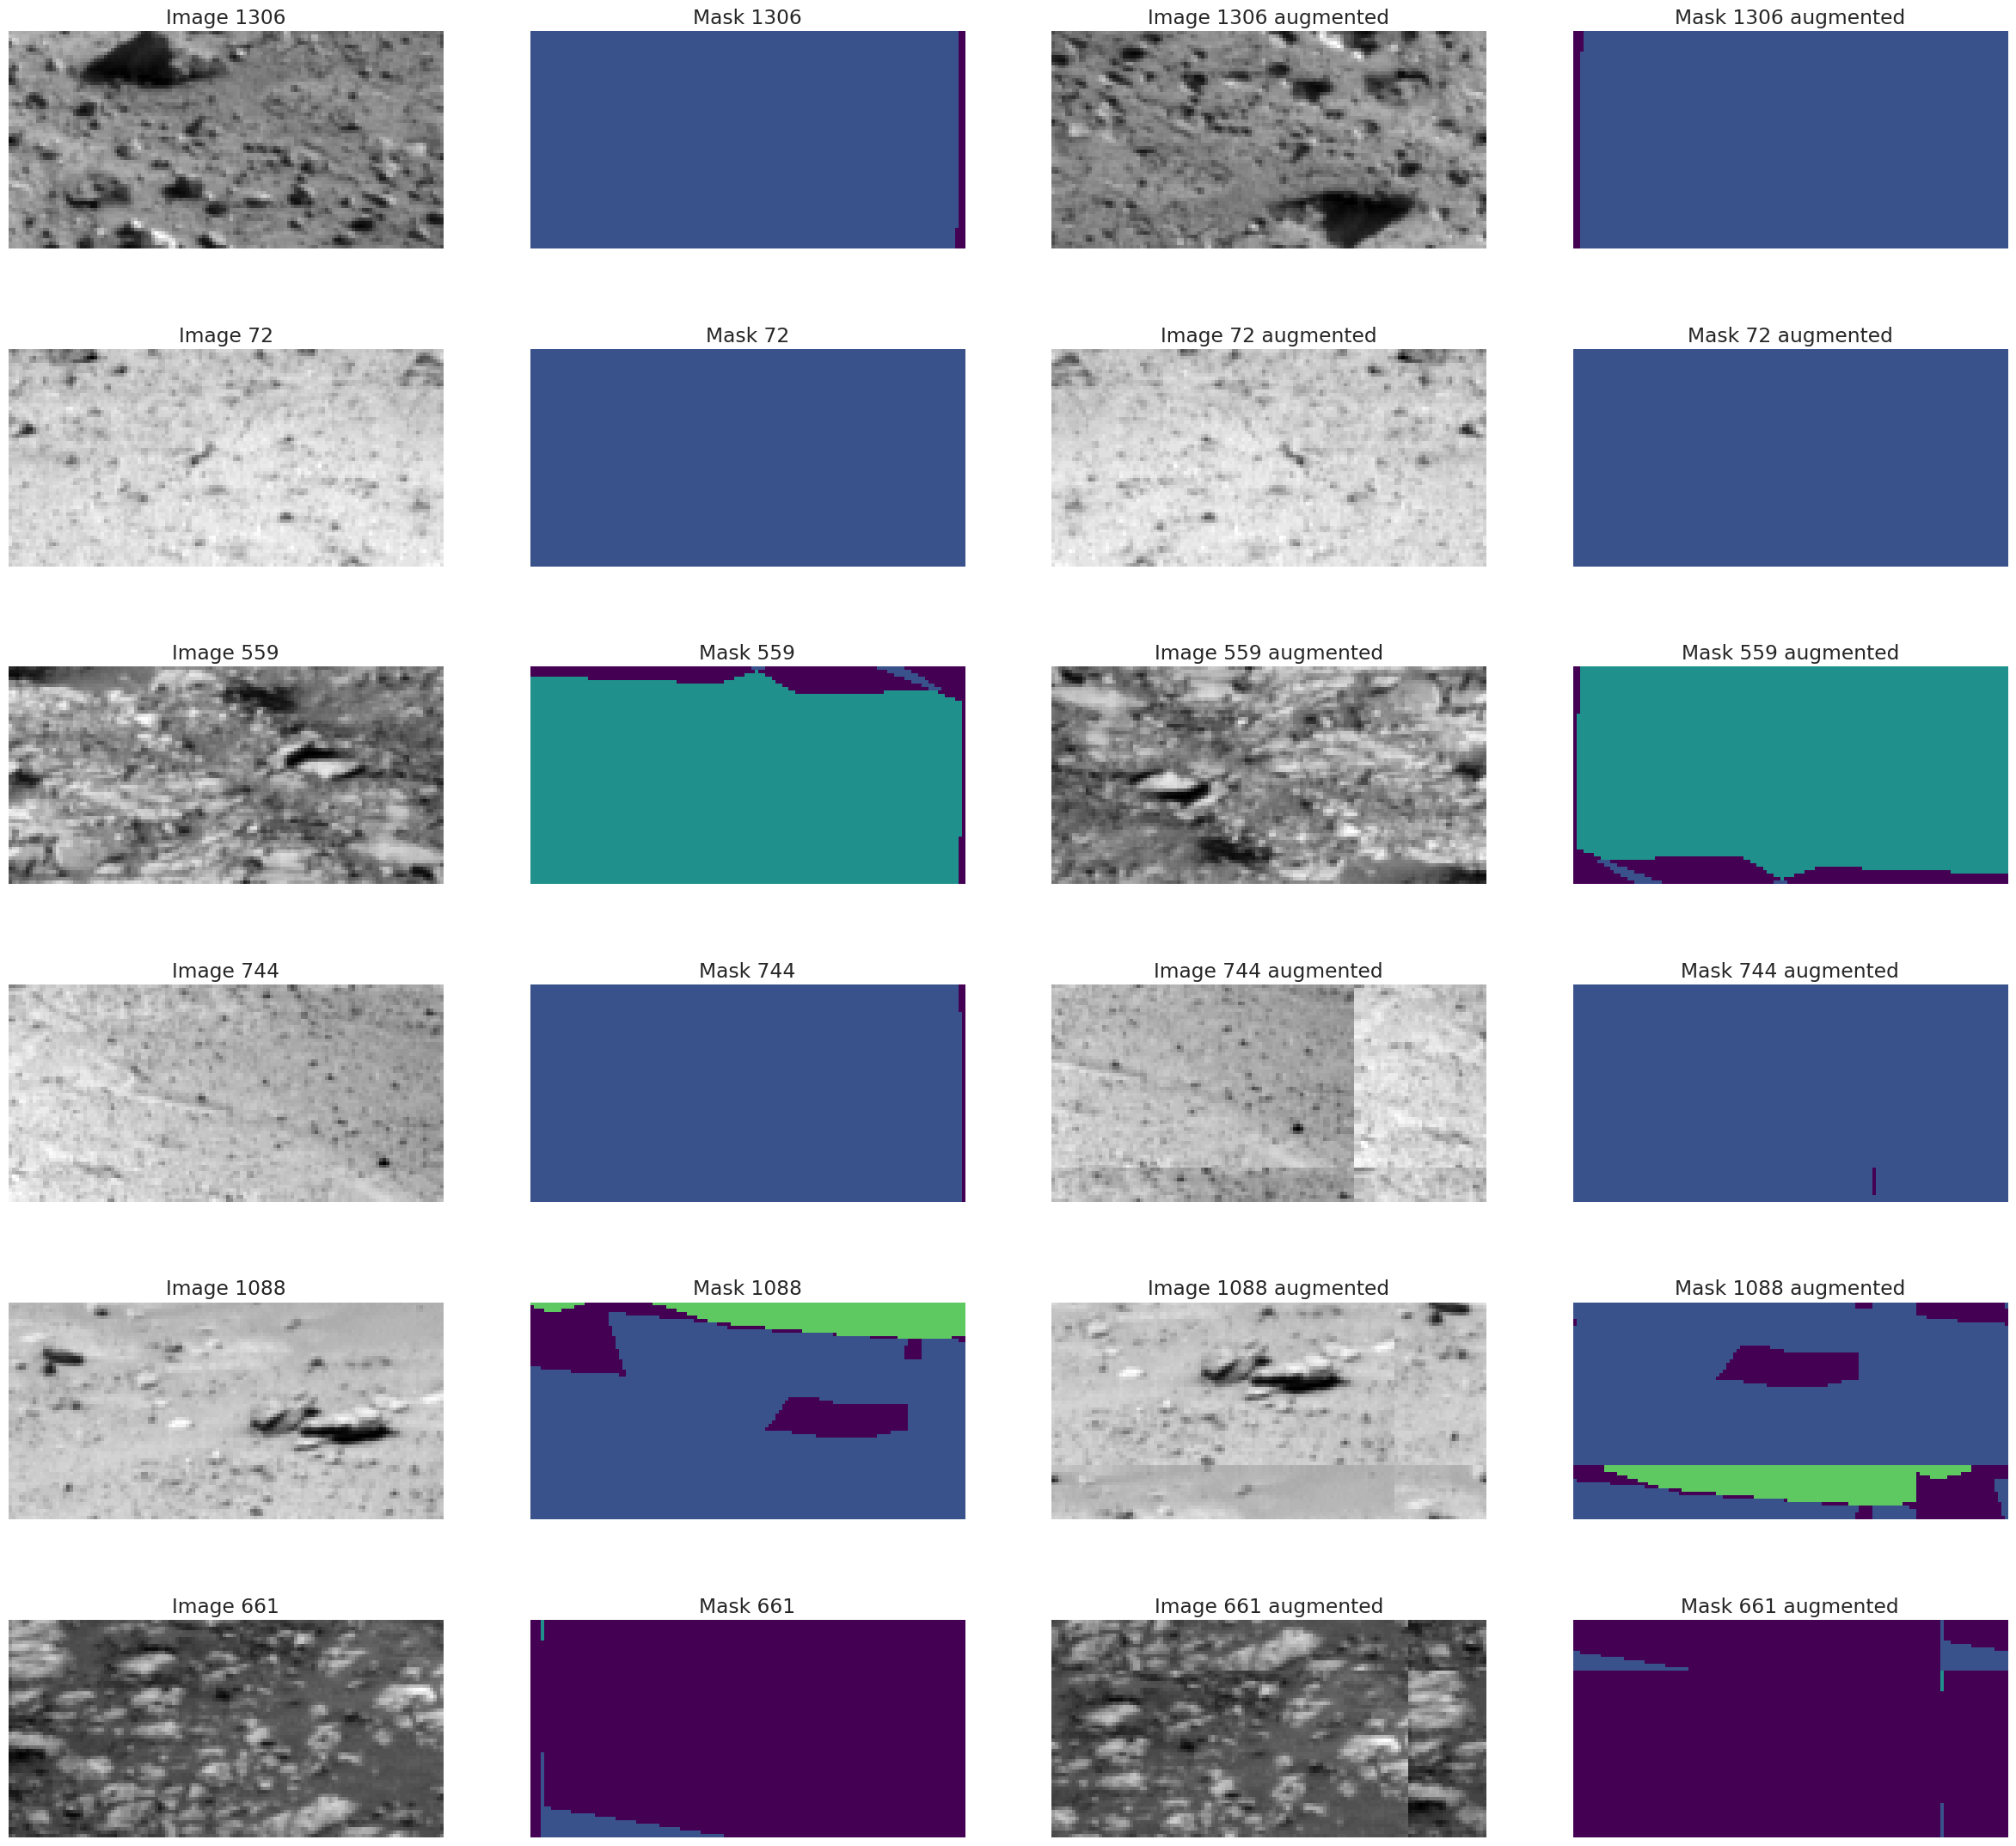

In [17]:
#test if the augmentations mantains the consistence between the image and its mask
num_row=6

fig, axes = plt.subplots(num_row, 4,figsize=(30,3*num_row+10))
iter=1
for i in range(num_row):
    index = np.random.randint(0,len(X_train))
    
    #plot the image
    ax=plt.subplot(num_row,4,iter)
    ax.set_title(f"Image {index}")
    ax.imshow(X_train[index],cmap='gray')
    ax.axis('off')

    iter=iter+1

    #plot the relative mask
    ax=plt.subplot(num_row,4,iter)
    ax.set_title(f"Mask {index}")
    colored_image = display_color_mapped_image_continuous(y_train[index])
    ax.imshow(np.squeeze(colored_image))
    ax.axis('off')
    iter=iter+1

    #augment image and mask
    Xaug,Yaug=RandomAugmentationCustom(X_train[index],y_train[index],False)

    #plot the augmented image
    ax=plt.subplot(num_row,4,iter)
    ax.set_title(f"Image {index} augmented")
    ax.imshow(np.squeeze(Xaug),cmap='gray')
    ax.axis('off')

    iter=iter+1

    #plot the relative augmented mask
    ax=plt.subplot(num_row,4,iter)
    ax.set_title(f"Mask {index} augmented")
    colored_image = display_color_mapped_image_continuous(np.array(Yaug))
    ax.imshow(np.squeeze(colored_image))
    ax.axis('off')
    iter=iter+1

plt.show()


In [18]:
def augment(X,Y,num,crop_bool,index_class=None):
    '''
    Prepare the images for the augmentation and store the results
    Input:
        -X: vector of images
        -Y: vector of the realative masks
        -num: number of images that adds
        -crop_bool: useless here is only passed to RandomAugmentCustom()
        -index_Class: vector taht contains the indexes of the images that need to be augmented.
                      if all the dataset needs to be augmented this is set to None and the first check initailize it 
    Output:
        -X: vector that contains the given images and the augmented ones
        -Y: vector that contains the given masks and the augmented ones 
    '''
    N=len(X)
    #initialize the vector that contains the indexes that are used in augmentations
    if index_class==None:
        index_class=range(N)
    
    #allocate the space in memory        
    X=np.resize(X,(num+N,64,128,1))
    Y=np.resize(Y,(num+N,64,128,1))    
    
    for i in range(N,num+N):
        index=np.random.choice(index_class)
        X[i],Y[i]=RandomAugmentationCustom(X[index],Y[index],crop_bool)

    return X,Y

So we augment the class 4 that is 'big rock'

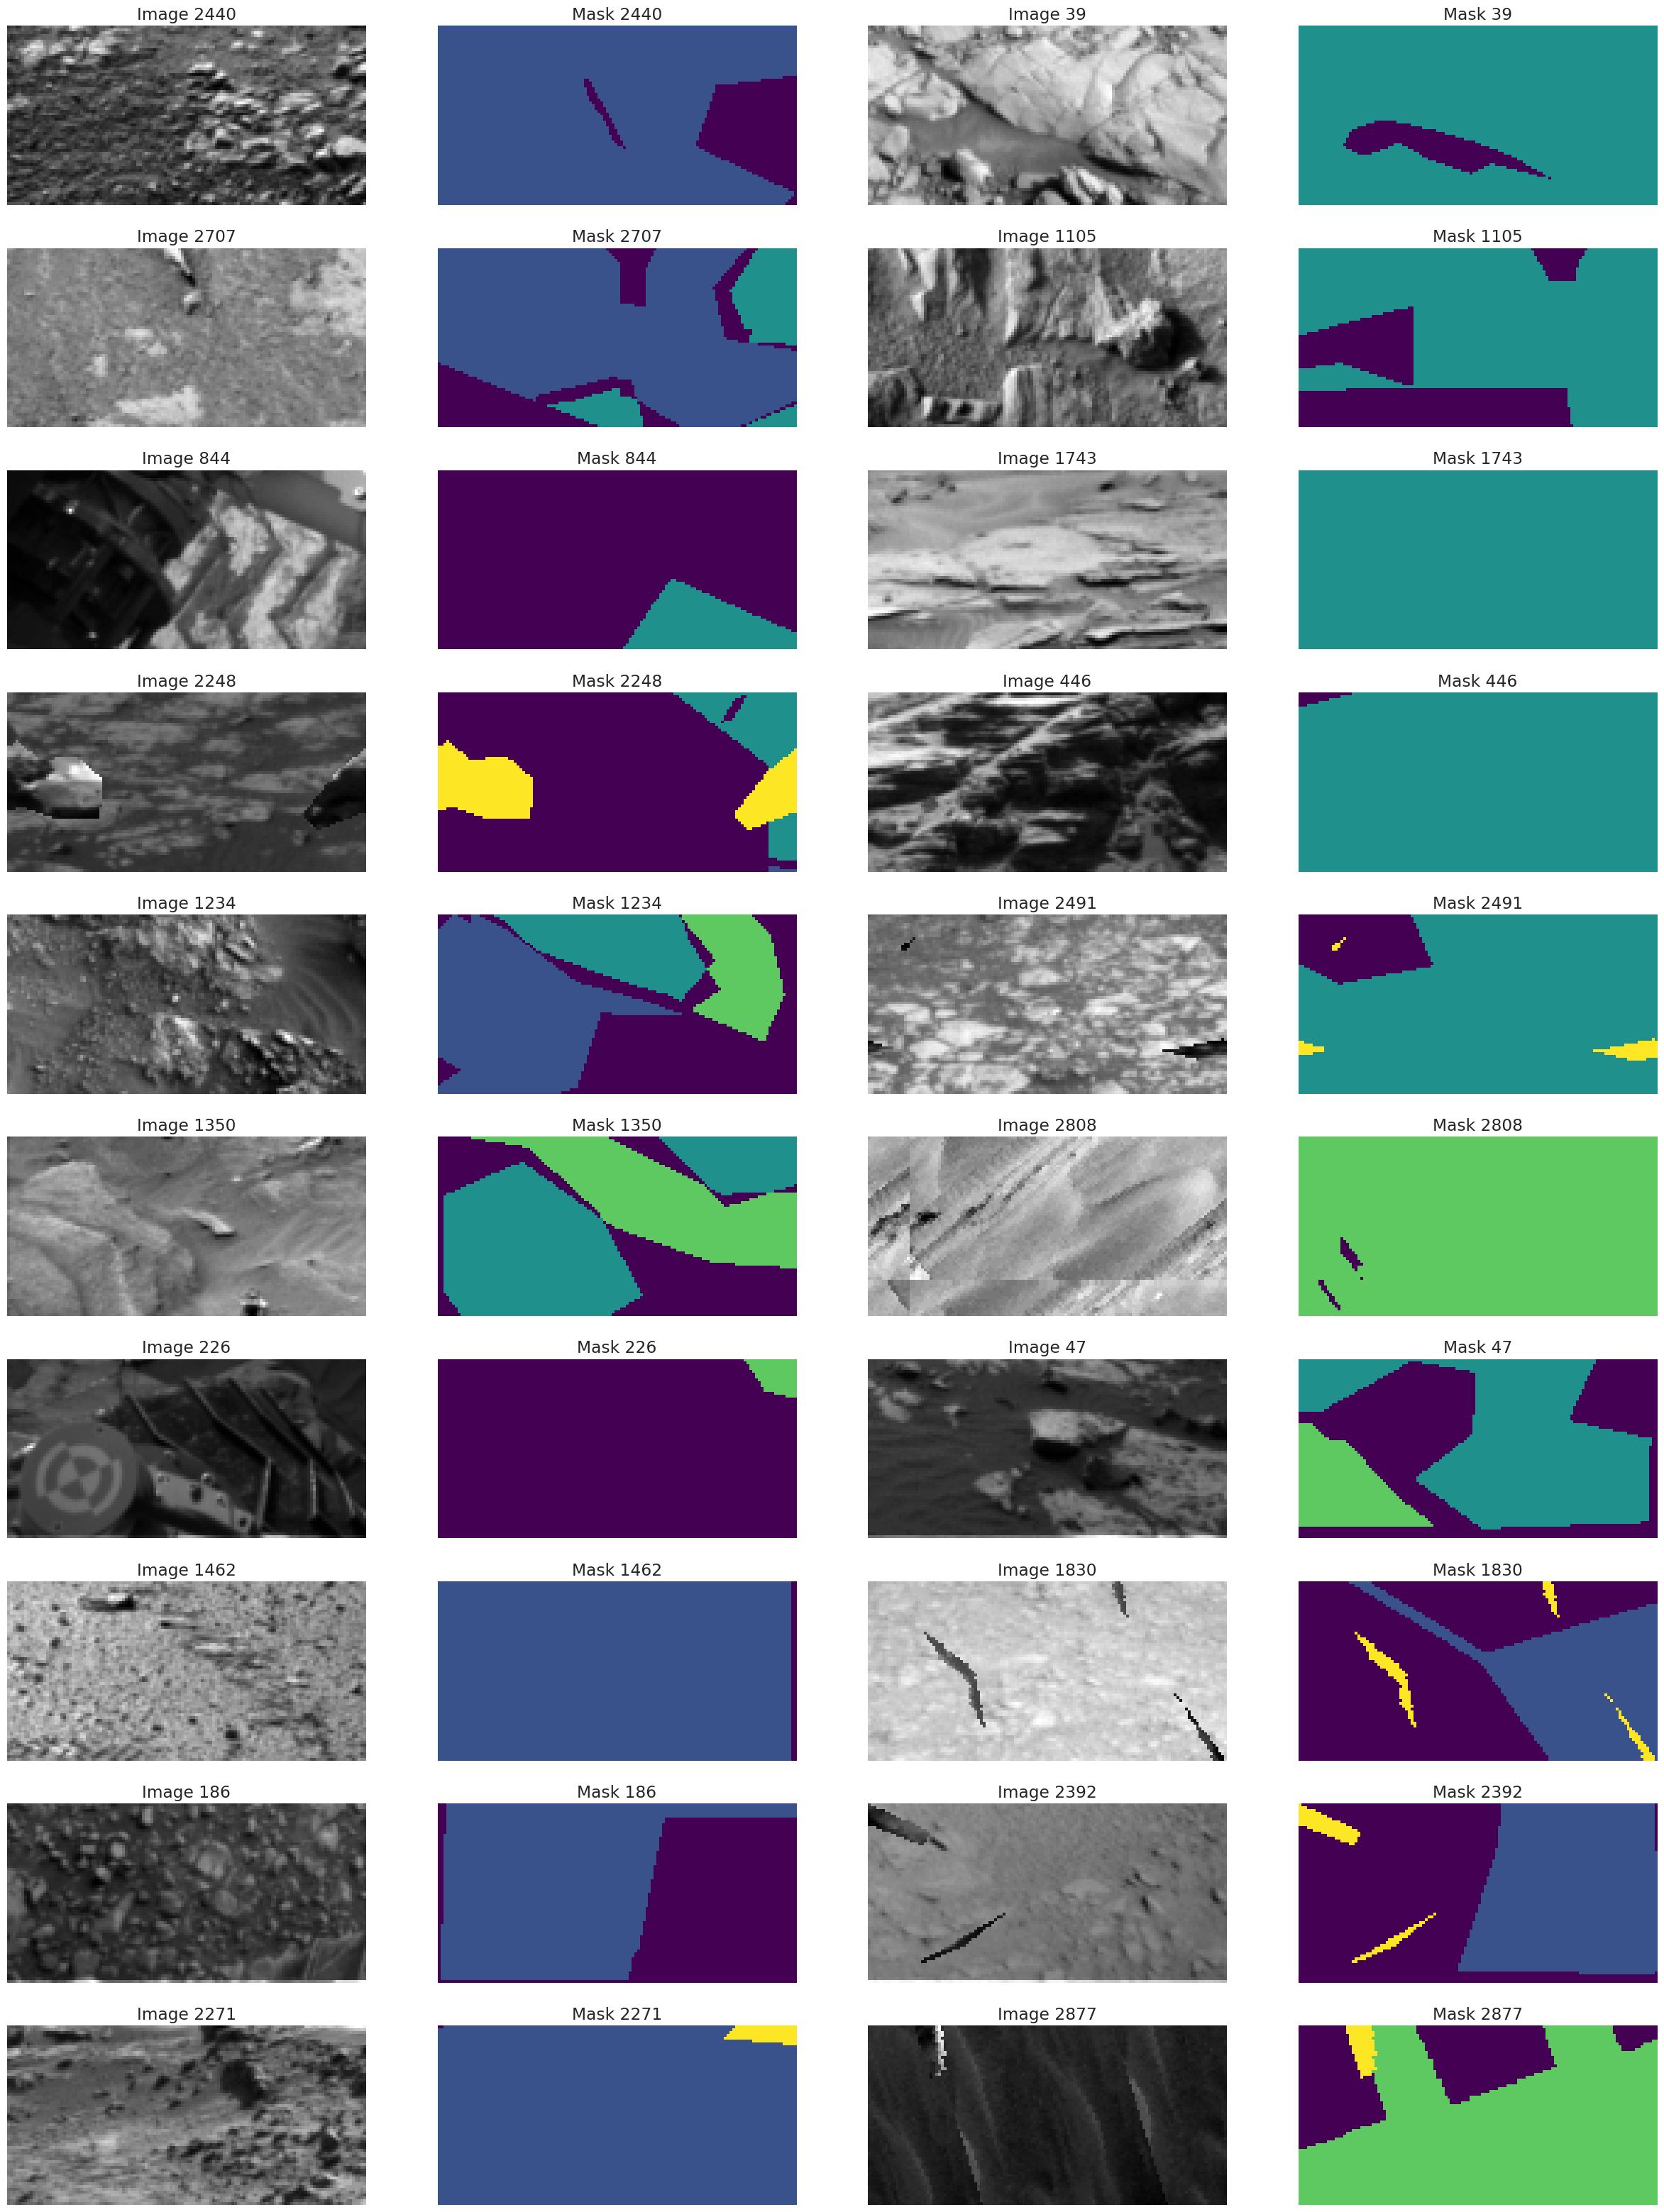

In [19]:
#apply the augemntation on the class 4
X_train,y_train=augment(X=X_train,Y=y_train,num=200,crop_bool=False,index_class=index_divided_class[-1])

# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

In [20]:
#check over the distribution and shape of the dataset
print(f'x_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nx_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nunique classes: {len(np.unique(y_train))}')
index_divided_class=count_img_per_class(y_train)

x_train shape: (2953, 64, 128, 1)
y_train shape: (2953, 64, 128, 1)
x_val shape: (752, 64, 128, 1)
y_val shape: (752, 64, 128)
unique classes: 5
Class 0 has 2493
Class 1 has 1470
Class 2 has 1443
Class 3 has 1039
Class 4 has 1063


Now we augment all the dataset

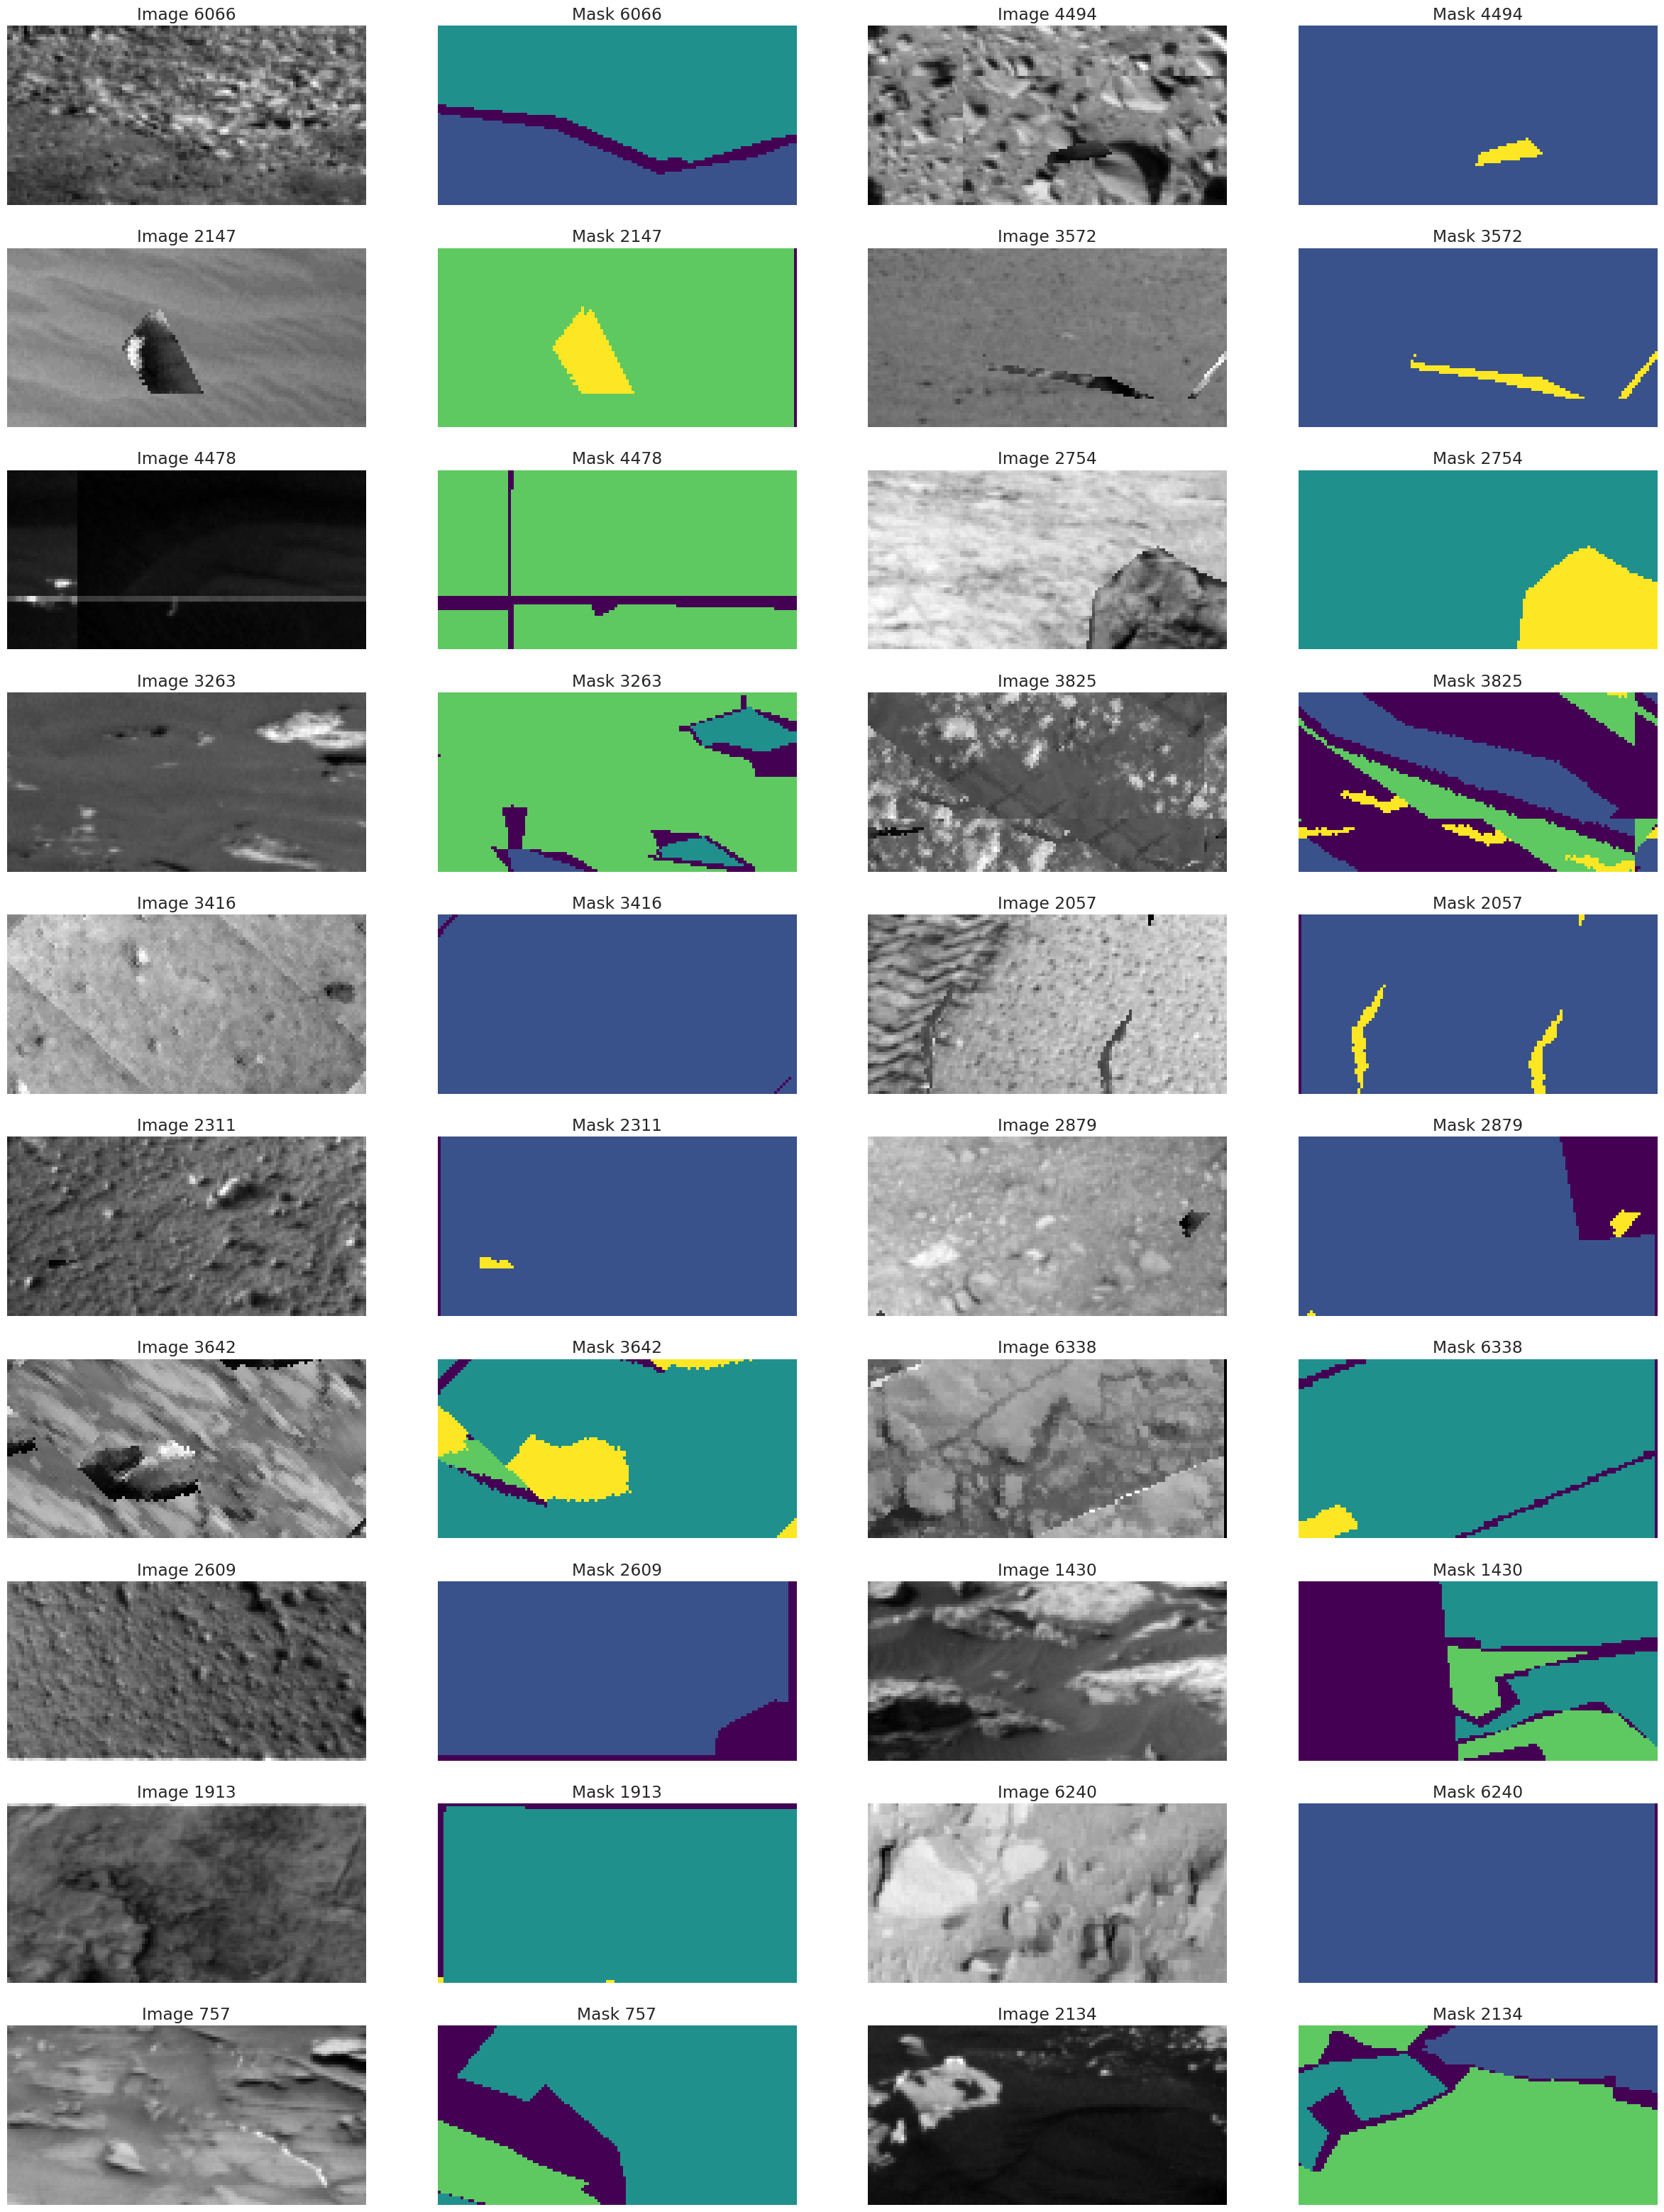

In [21]:
#apply the augmentation on the entire dataset
X_train,y_train=augment(X_train,y_train,6400-len(X_train),True)

# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

In [22]:
#check the distribution and the shape of the dataset
print(f'x_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nx_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nunique classes : {len(np.unique(y_train))}')
index_divided_class=count_img_per_class(y_train)

x_train shape: (6400, 64, 128, 1)
y_train shape: (6400, 64, 128, 1)
x_val shape: (752, 64, 128, 1)
y_val shape: (752, 64, 128)
unique classes : 5
Class 0 has 5223
Class 1 has 3172
Class 2 has 3042
Class 3 has 2192
Class 4 has 2174


# Save the dataset

In [23]:
np.savez_compressed('mars_for_students_aug.npz',X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,X_test=X_test)